# Sensitivity Analysis (GP)

This notebook contains code used to perform sensitivity analysis using GP.

In [164]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML
from copy import deepcopy
import random
import pickle
import GPy
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core.loop import UserFunctionWrapper
import matplotlib.pyplot as plt
from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
import matplotlib.style as style

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

import warnings
warnings.filterwarnings('ignore')
style.use('fivethirtyeight')

In [165]:
%run utilities.ipynb

## Experimentations

In [3]:
# Load data
over18 = load_csv("../data/bbc-pandemic/contact_distributions_o18.csv")
under18 = load_csv("../data/bbc-pandemic/contact_distributions_u18.csv")

### ANOVA of all variables 

The fourteen variables include general, policy, and compliance factors. We observed their contribution to the simulator function computing the effective *R* rate.

In [204]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = list(range(2, 14))
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('home_sar', *reduced_variable_domain),
           ContinuousParameter('work_sar', *reduced_variable_domain),
           ContinuousParameter('other_sar', *reduced_variable_domain),
           ContinuousParameter('p_under18', *variable_domain),
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           DiscreteParameter('testing_delay', delay_domain), 
           DiscreteParameter('app_trace_delay', delay_domain), 
           DiscreteParameter('manual_trace_delay', delay_domain), 
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('max_contacts', max_contacts_domain),
           ContinuousParameter('compliance', *variable_domain), 
           ContinuousParameter('app_coverage', *variable_domain),               
           ])

#### GP Monte Carlo

In [205]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_all(x)
model_gpy = GPRegression(x,y)
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

Optimization restart 1/1, f = 16.948978089187396


In [206]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_all, 10)

Optimization restart 1/1, f = 16.948978089187396
Optimization restart 1/1, f = 15.905057685062436
Optimization restart 1/1, f = 19.418575894127294
Optimization restart 1/1, f = 21.48313570717702
Optimization restart 1/1, f = 23.559414115607332
Optimization restart 1/1, f = 25.247910572219162
Optimization restart 1/1, f = 26.465009457332698
Optimization restart 1/1, f = 27.46809153399667
Optimization restart 1/1, f = 29.160894392031445
Optimization restart 1/1, f = 30.469542300943637
Optimization restart 1/1, f = 31.92357761327804


In [207]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [ ]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_all, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

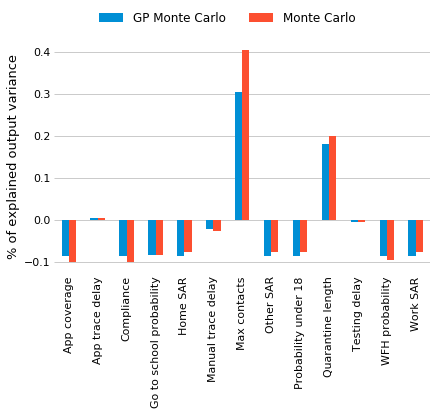

In [219]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "App trace delay",
                   "Compliance", "Go to school probability",
                   "Home SAR", "Manual trace delay",
                   "Max contacts", "Other SAR",
                   "Probability under 18", "Quarantine length",
                   "Testing delay", "WFH probability",
                   "Work SAR"], rotation=90)
# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

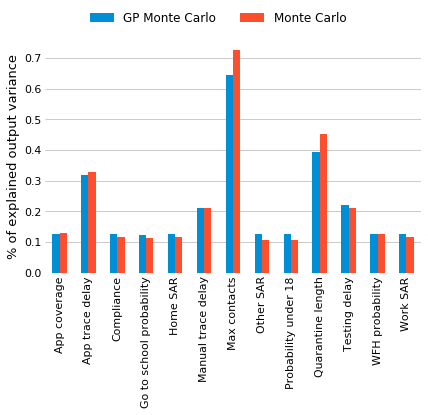

In [225]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_gp_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")
ax.set_xticklabels(["App coverage", "App trace delay",
                   "Compliance", "Go to school probability",
                   "Home SAR", "Manual trace delay",
                   "Max contacts", "Other SAR",
                   "Probability under 18", "Quarantine length",
                   "Testing delay", "WFH probability",
                   "Work SAR"], rotation=90)

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [ ]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-all.csv")

### ANOVA of compliance factor variables

The compliance factor variables, including app_coverage and compliance. We observed their contribution to the simulator function computing the effective *R* rate.

In [112]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = list(range(2, 14))
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('compliance', *variable_domain), 
           ContinuousParameter('app_coverage', *variable_domain), 
           ])

#### GP Monte Carlo

In [113]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_compliance(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.7628305443526777


In [114]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_compliance, 10)

Optimization restart 1/1, f = 0.7628305443526777



Optimization restart 1/1, f = -0.7975560297470894



Optimization restart 1/1, f = -3.3154330891580077



Optimization restart 1/1, f = -5.796047139509977



Optimization restart 1/1, f = -3.1637849354523784



Optimization restart 1/1, f = -4.842505524671839



Optimization restart 1/1, f = -8.714165516105748



Optimization restart 1/1, f = 5.890713411495685



Optimization restart 1/1, f = 4.7428807227121155



Optimization restart 1/1, f = 5.190346691736831



Optimization restart 1/1, f = 6.290540857755072


In [115]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [52]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_compliance, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

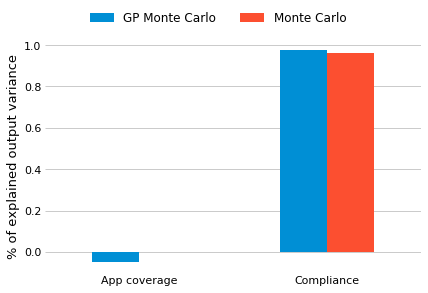

In [122]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

## Load first
# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

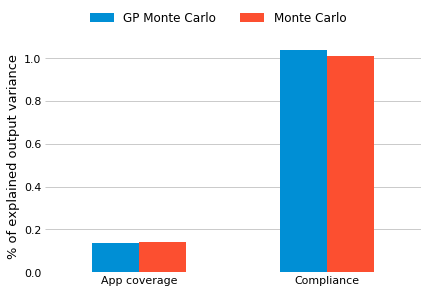

In [128]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["App coverage", "Compliance"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [55]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-compliance.csv")

### ANOVA of general factor variables

The general factor variables, including secondary attack rates and probability of case under 18. We observed their contribution to the simulator function computing the effective *R* rate.

In [133]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = list(range(2, 14))
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('home_sar', *reduced_variable_domain),
           ContinuousParameter('work_sar', *reduced_variable_domain),
           ContinuousParameter('other_sar', *reduced_variable_domain),
           ContinuousParameter('p_under18', *variable_domain),
           ])

#### GP Monte Carlo

In [134]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_general(x)
model_gpy = GPRegression(x,y)
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 13.05601306099256


In [135]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_general, 10)

Optimization restart 1/1, f = 13.05601306099256



Optimization restart 1/1, f = 14.824599725371215



Optimization restart 1/1, f = 16.11823003747905



Optimization restart 1/1, f = 17.073909788166



Optimization restart 1/1, f = 16.428361201520836



Optimization restart 1/1, f = 16.094314545528242



Optimization restart 1/1, f = 14.52985209131031



Optimization restart 1/1, f = 15.054098040595283



Optimization restart 1/1, f = 18.077733520918947



Optimization restart 1/1, f = 18.622470787572382



Optimization restart 1/1, f = 23.956650220275908


In [136]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [151]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_general, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

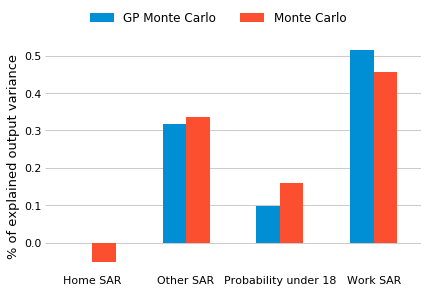

In [144]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["Home SAR", "Other SAR", "Probability under 18", "Work SAR"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

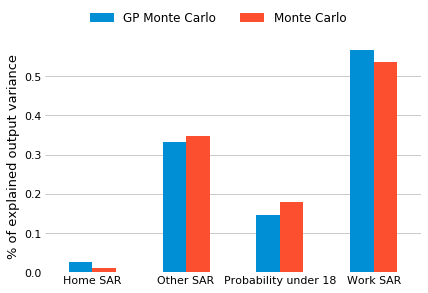

In [155]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["Home SAR", "Other SAR", "Probability under 18", "Work SAR"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [ ]:
## Save experiment results
d = {
        'total_effects_gp': total_effects_gp_plot,
        'total_effects': total_effects_plot,
        'main_effects_gp': main_effects_gp_plot,
        'main_effects': main_effects_plot
    }

pd.DataFrame(d).to_csv("../results/gp-general.csv")

### ANOVA of policy factor variables

The policy factor variables. We observed their contribution to the simulator function computing the effective *R* rate.

In [166]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(0, 2)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
#            DiscreteParameter('testing_delay', delay_domain), 
#            DiscreteParameter('app_trace_delay', delay_domain), 
#            DiscreteParameter('manual_trace_delay', delay_domain), 
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('max_contacts', max_contacts_domain), 
           ])

#### GP Monte Carlo

In [167]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_policy(x)
model_gpy = GPRegression(x,y)
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 1.584306389674687


In [168]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_policy, 10)

Optimization restart 1/1, f = 1.584306389674687



Optimization restart 1/1, f = 2.6084322191407097



Optimization restart 1/1, f = 2.0751258801034034



Optimization restart 1/1, f = 1.5968152454025129



Optimization restart 1/1, f = 2.6941586857048874



Optimization restart 1/1, f = 1.8447988059451088



Optimization restart 1/1, f = 1.375053839787606



Optimization restart 1/1, f = 6.546256893684552



Optimization restart 1/1, f = 5.970727612486931



Optimization restart 1/1, f = 5.868848113342394



Optimization restart 1/1, f = 7.173056544249908


In [169]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [189]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_policy, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

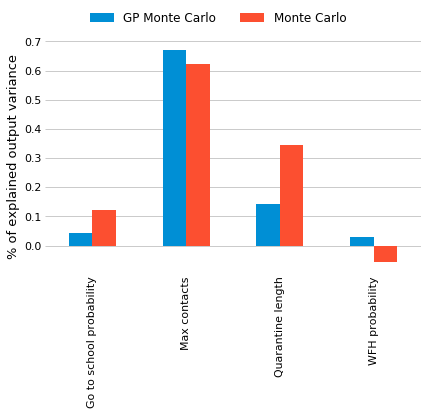

In [230]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["Go to school probability", "Max contacts", "Quarantine length", "WFH probability"], rotation=90)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

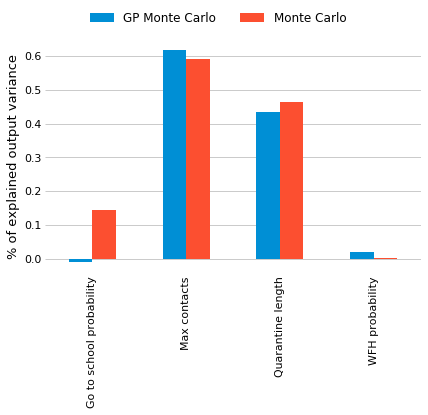

In [229]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["Go to school probability", "Max contacts", "Quarantine length", "WFH probability"], rotation=90)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [ ]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-policy.csv")

### ANOVA of WFH and GTS

We observed their contribution to the simulator function computing the effective *R* rate.

In [70]:
## Setup parameter spaces
variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(0, 2)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           ])

#### GP Monte Carlo

In [71]:
# Initialise model
design = RandomDesign(space)
x = design.get_samples(5)
y = gp_simulation_result_wfh(x)
model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()


Optimization restart 1/1, f = 0.5087491284472403


In [72]:
# Optimised model
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition=integrated_variance)
ed.run_loop(gp_simulation_result_wfh, 10)

Optimization restart 1/1, f = 0.5087491284472403



Optimization restart 1/1, f = -0.07127423350912876



Optimization restart 1/1, f = 0.027802566784395744



Optimization restart 1/1, f = -1.0483482844759378



Optimization restart 1/1, f = -2.403039121305379



Optimization restart 1/1, f = -3.308894306633528



Optimization restart 1/1, f = -4.632209005724546



Optimization restart 1/1, f = -6.294787865331127



Optimization restart 1/1, f = -8.042348749849399



Optimization restart 1/1, f = -9.613679013672806



Optimization restart 1/1, f = -11.27494913625338


In [73]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model=model_emukit, input_domain=space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

#### Monte Carlo

In [ ]:
num_mc = 10000
senstivity = ModelFreeMonteCarloSensitivity(gp_simulation_result_wfh, space)
main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points=num_mc)

#### Plot

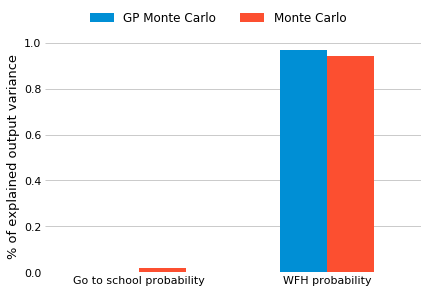

In [84]:
## Main effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

# main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}
# main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

# d = {
#         'GP Monte Carlo': main_effects_gp_plot,
#         'Monte Carlo': main_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["Go to school probability", "WFH probability"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

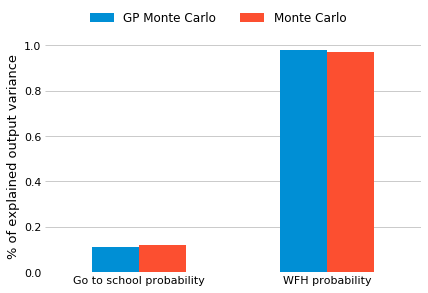

In [110]:
## Total effects
fig, ax = plt.subplots(figsize=(6, 4), facecolor="white")

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
# total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

## Load from CSV if dont want to run experiments
# d = {
#         'GP Monte Carlo': total_effects_gp_plot,
#         'Monte Carlo': total_effects_plot
#     }

pd.DataFrame(d).plot(kind='bar', ax=ax)

# Label
ax.set_ylabel('% of explained output variance', fontsize=13)
ax.set_facecolor("white")

# Despine
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0)

# Ticks
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xticklabels(["Go to school probability", "WFH probability"], rotation=0)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=["GP Monte Carlo", "Monte Carlo"], loc='center left', 
           bbox_to_anchor=(0.09, 1.09), ncol=2, frameon=False,
          prop={'size': 12})

# Grid
plt.grid(False)
ax.yaxis.grid()

plt.show()

In [111]:
# ## Save experiment results
# d = {
#         'total_effects_gp': total_effects_gp_plot,
#         'total_effects': total_effects_plot,
#         'main_effects_gp': main_effects_gp_plot,
#         'main_effects': main_effects_plot
#     }

# pd.DataFrame(d).to_csv("../results/gp-wfh.csv")